<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/GAN_torch_withPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#torch.multiprocessing.set_start_method("spawn") 

import torch.optim
print(torch.__version__)
#from torch import np

import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot     
from sklearn.metrics import accuracy_score


# Target Model definition - LeNet 5
class target_net(nn.Module):
    def __init__(self):
        super(target_net, self).__init__()

        # LAYER 1: Convolution, Input 1x32x32, Output 6x28x28
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling, Input 6x28x28, Output 6x14x14
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout
        self.drop1 = torch.nn.Dropout(0.2)
       
        # LAYER 2: Convolution, Input 6x14x14, Output 16x10x10
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling, Input 16x10x10, Output 16x5x5
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) 
        # Dropout
        self.drop2 = torch.nn.Dropout(0.2)
        
        # LAYER 3: FC, Input 400, Output 120
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.drop3 = torch.nn.Dropout(0.4)
        
        # LAYER 4: FC, Input 120, Output 84
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.drop4 = torch.nn.Dropout(0.4)
        
        # LAYER 5: FC Input 84, Output 43
        self.fc3 = torch.nn.Linear(84, 43)        # convert matrix with 84 features to a matrix of 43 features (columns)
        


    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return x


class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        # Traffic Sign Dataset: 1*32x32
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            # 8*16*16
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # 16*5*5
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
            # 32*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output


class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # Traffic Sign Dataset:1*32x32
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 32 x 32
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x


# Define a resnet block
# modified from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out
    


1.1.0


In [0]:
#Data loading and preprocessing

import pickle
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from torch.utils.data import TensorDataset

import keras
from keras.utils import to_categorical

training_file = 'train.p'
testing_file = 'test.p'
validation_file = 'valid.p'

with open(training_file, mode='rb') as f:
    tstrain = pickle.load(f)
with open(testing_file, mode='rb') as f:
    tstest = pickle.load(f)
with open(validation_file, mode='rb') as f:
    tsvalid = pickle.load(f)

X_train, Y_train = tstrain['features'], tstrain['labels']
X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
X_test, Y_test = tstest['features'], tstest['labels']

#shuffle training set
X_train, Y_train = shuffle(X_train, Y_train, random_state=33)
X_test, Y_test = shuffle(X_test, Y_test, random_state=33)
X_valid, Y_valid = shuffle(X_valid, Y_valid, random_state=33)

#grayscale images
grayscale = [0.299,0.587,0.144]

X_test = np.dot(X_test, grayscale)
X_train = np.dot(X_train, grayscale)
X_valid = np.dot(X_valid, grayscale)


#normalize
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_valid = np.array(X_valid)/255

#expand dimensions to fit 4D input array
X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)
X_valid = np.expand_dims(X_valid,-1)

X_train = np.transpose(X_train, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))
X_valid = np.transpose(X_valid, (0,3,1,2))

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)

#Y_train = Y_train.reshape(Y_train.shape[0],1)
#Y_test = Y_test.reshape(Y_test.shape[0],1)
#Y_valid = Y_valid.reshape(Y_valid.shape[0],1)
Y_train = to_categorical(Y_train, num_classes=43)
Y_test = to_categorical(Y_test, num_classes=43)
Y_valid = to_categorical(Y_valid, num_classes=43)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_valid.shape)
print(Y_valid.shape)

train_x = torch.stack([torch.Tensor(i) for i in X_train])
train_y = torch.stack([torch.LongTensor(i) for i in Y_train])

test_x = torch.stack([torch.Tensor(i) for i in X_test])
test_y = torch.stack([torch.LongTensor(i) for i in Y_test])

valid_x = torch.stack([torch.Tensor(i) for i in X_valid])
valid_y = torch.stack([torch.LongTensor(i) for i in Y_valid])

train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
valid_dataset = TensorDataset(valid_x,valid_y)




Using TensorFlow backend.


(34799, 1, 32, 32)
(34799, 43)
(12630, 1, 32, 32)
(12630, 43)
(4410, 1, 32, 32)
(4410, 43)


In [83]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


if __name__ == "__main__":
    use_cuda = True
    image_nc = 1 #number of channels
    batch_size = 128

    # Define what device we are using
    print("CUDA Available: ", torch.cuda.is_available())
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

    
    #Training set

    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, shuffle=False, num_workers=1)


    # training the target model
    target_model = target_net().to(device)
    target_model.train()
    opt_model = torch.optim.Adam(target_model.parameters(), lr=0.001)
    epochs = 20
    
    for epoch in range(epochs):
        loss_epoch = 0
        num_acc_correct = 0
        if epoch == 20:
            opt_model = torch.optim.Adam(target_model.parameters(), lr=0.0001)
        for i, data in enumerate(train_dataloader, 0):
            train_imgs, train_labels = data
            train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
            logits_model = target_model(train_imgs)
            loss_model = F.cross_entropy(logits_model, torch.max(train_labels,1)[1])
            loss_epoch += loss_model
            
            #stuff for accuracy
            train_label = torch.argmax(train_labels,1)
            pred_train = torch.argmax(logits_model,1)
            num_acc_correct += torch.sum(pred_train==train_label,0)
            
            opt_model.zero_grad()
            loss_model.backward()
            opt_model.step()
        
        print('loss in epoch %d: %f\n' % (epoch, loss_epoch.item()))
        print('Train accuracy so far: %f\n'%(100*num_acc_correct.item()/len(train_dataset)))

    # save model
    targeted_model_file_name = './target_model.pth'
    torch.save(target_model.state_dict(), targeted_model_file_name)
    target_model.eval()

    # TESTING
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                 shuffle=False, num_workers=1)
    
    num_correct = 0
    for i, data in enumerate(test_dataloader, 0):
        test_img, test_label = data
        test_img, test_label = test_img.to(device), test_label.to(device)
        test_label = torch.argmax(test_label,1)
        pred_lab = torch.argmax(target_model(test_img), 1)
        num_correct += torch.sum(pred_lab==test_label,0)

    print('accuracy in testing set: %f\n'%(100*num_correct.item()/len(test_dataset)))

CUDA Available:  True
loss in epoch 0: 776.634705

Train accuracy so far: 22.310986

loss in epoch 1: 299.388092

Train accuracy so far: 67.815167

loss in epoch 2: 174.411636

Train accuracy so far: 82.197764

loss in epoch 3: 124.756775

Train accuracy so far: 87.628955

loss in epoch 4: 96.479652

Train accuracy so far: 90.554326

loss in epoch 5: 77.146271

Train accuracy so far: 92.525647

loss in epoch 6: 63.723629

Train accuracy so far: 93.996954

loss in epoch 7: 53.523987

Train accuracy so far: 94.968246

loss in epoch 8: 45.486923

Train accuracy so far: 95.810224

loss in epoch 9: 39.466923

Train accuracy so far: 96.350470

loss in epoch 10: 34.115372

Train accuracy so far: 96.890715

loss in epoch 11: 29.913654

Train accuracy so far: 97.278657

loss in epoch 12: 27.530382

Train accuracy so far: 97.370614

loss in epoch 13: 24.474691

Train accuracy so far: 97.657979

loss in epoch 14: 22.111988

Train accuracy so far: 97.930975

loss in epoch 15: 19.186552

Train accu

In [0]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

import torch.nn as nn
import torch
#import numpy as np

import torch.nn.functional as F
import torchvision
import os

#models_path = './models/'


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class AdvGAN_Attack:
    def __init__(self,
                 device,
                 model,
                 model_num_labels,
                 image_nc,
                 box_min,
                 box_max):
        output_nc = image_nc
        self.device = device
        self.model_num_labels = model_num_labels
        self.model = model
        self.input_nc = image_nc
        self.output_nc = output_nc
        self.box_min = box_min
        self.box_max = box_max

        self.gen_input_nc = image_nc
        self.netG = Generator(self.gen_input_nc, image_nc).to(device)
        self.netDisc = Discriminator(image_nc).to(device)

        # initialize all weights
        self.netG.apply(weights_init)
        self.netDisc.apply(weights_init)

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=0.001)
        self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                            lr=0.001)

    def train_batch(self, x, labels):
        # optimize D
        for i in range(1):
            perturbation = self.netG(x)

            # add a clipping trick
            adv_images = torch.clamp(perturbation, -0.01, 0.01) + x
            adv_images = torch.clamp(adv_images, self.box_min, self.box_max)

            self.optimizer_D.zero_grad()
            pred_real = self.netDisc(x)
            loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real, device=self.device))
            loss_D_real.backward()

            pred_fake = self.netDisc(adv_images.detach())
            loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device))
            loss_D_fake.backward()
            loss_D_GAN = loss_D_fake + loss_D_real
            self.optimizer_D.step()

        # optimize G
        for i in range(1):
            self.optimizer_G.zero_grad()

            # cal G's loss in GAN
            pred_fake = self.netDisc(adv_images)
            loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake, device=self.device))
            loss_G_fake.backward(retain_graph=True)

            # calculate perturbation norm
            C = 0.1
            loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))
            # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))
            
            
            # cal adv loss
            logits_model = self.model(adv_images)
            probs_model = F.softmax(logits_model, dim=1)
            #print("logits model")
            #print(logits_model.shape)
            onehot_labels = labels.type(torch.cuda.FloatTensor)   #torch.eye(self.model_num_labels, device=self.device)[labels]
            #print(onehot_labels.shape)
            #print("one hot labels")
            #print(onehot_labels)
            #print(probs_model.shape)
            #print('probs_model')
            #print(probs_model)

            # C&W loss function
            
            real = torch.sum(onehot_labels * probs_model, dim=1)
            other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
            zeros = torch.zeros_like(other)
            loss_adv = torch.max(real - other, zeros)
            loss_adv = torch.sum(loss_adv)

            # maximize cross_entropy loss
            # loss_adv = -F.mse_loss(logits_model, onehot_labels)
            # loss_adv = - F.cross_entropy(logits_model, labels)

            adv_lambda = 10
            pert_lambda = 1
            loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
            loss_G.backward()
            self.optimizer_G.step()

        return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

    def train(self, train_dataloader, epochs):
        for epoch in range(1, epochs+1):

            if epoch == 50:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.0001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.0001)
            if epoch == 80:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.00001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.00001)
            loss_D_sum = 0
            loss_G_fake_sum = 0
            loss_perturb_sum = 0
            loss_adv_sum = 0
            
            
            #For accuracy calculation
            num_correct = 0
             
            
            for i, data in enumerate(train_dataloader, start=0):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                
                perturbation = self.netG(images)
                # add a clipping trick
                adv_images = torch.clamp(perturbation, -0.01, 0.01) + images
                adv_images = torch.clamp(adv_images, self.box_min, self.box_max)
                

                #print('labels shape')
                #print(labels.shape)
                #print('images shape')
                #print(images.shape)
                
                loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch = \
                    self.train_batch(images, labels)
                loss_D_sum += loss_D_batch
                loss_G_fake_sum += loss_G_fake_batch
                loss_perturb_sum += loss_perturb_batch
                loss_adv_sum += loss_adv_batch
                
                #calculate accuracy
                train_label = torch.argmax(labels,1)
                pred_label = torch.argmax(targeted_model(adv_images), 1)
                num_correct += torch.sum(pred_label==train_label,0)
                
                

            # print statistics
            num_batch = len(train_dataloader)
            print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f,\
             \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
                  (epoch, loss_D_sum/num_batch, loss_G_fake_sum/num_batch,
                   loss_perturb_sum/num_batch, loss_adv_sum/num_batch))
            print('accuracy in training set after perturbation: %f\n'%(100*num_correct.item()/len(train_dataset)))
            #plt.imshow(images[10].cpu().permute(1, 2, 0))
            #plt.imshow(adv_images[10].cpu().permute(1, 2, 0))
            
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(transforms.ToPILImage()(images[10].cpu()), interpolation="bicubic",cmap='gray')
            axarr[1].imshow(transforms.ToPILImage()(adv_images[10].cpu()), interpolation="bicubic",cmap='gray')
            plt.show()



            # save generator
            if epoch%20==0:
                netG_file_name = models_path + 'netG_epoch_' + str(epoch) + '.pth'
                torch.save(self.netG.state_dict(), netG_file_name)


CUDA Available:  True
accuracy in testing set: 87.117973

epoch 1:
loss_D: 0.500, loss_G_fake: 0.251,             
loss_perturb: 9.193, loss_adv: 116.247, 

accuracy in training set after perturbation: 95.129170



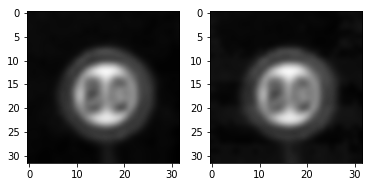

epoch 2:
loss_D: 0.438, loss_G_fake: 0.296,             
loss_perturb: 10.660, loss_adv: 107.340, 

accuracy in training set after perturbation: 89.258312



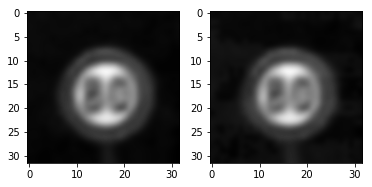

epoch 3:
loss_D: 0.367, loss_G_fake: 0.362,             
loss_perturb: 9.818, loss_adv: 104.120, 

accuracy in training set after perturbation: 86.758240



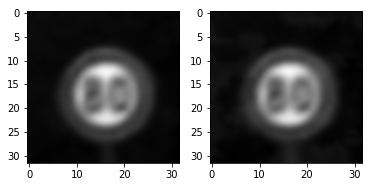

epoch 4:
loss_D: 0.376, loss_G_fake: 0.359,             
loss_perturb: 9.309, loss_adv: 101.992, 

accuracy in training set after perturbation: 85.080031



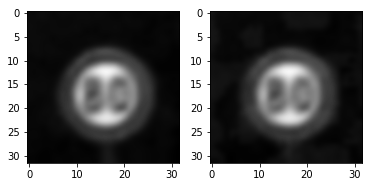

epoch 5:
loss_D: 0.372, loss_G_fake: 0.365,             
loss_perturb: 8.749, loss_adv: 100.542, 

accuracy in training set after perturbation: 83.996667



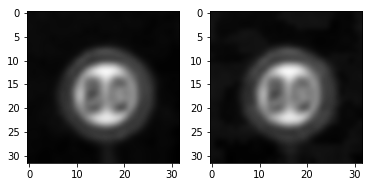

epoch 6:
loss_D: 0.354, loss_G_fake: 0.380,             
loss_perturb: 7.765, loss_adv: 98.842, 

accuracy in training set after perturbation: 82.832840



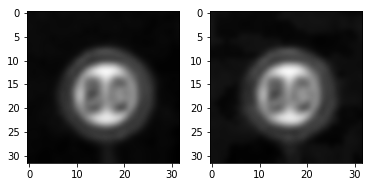

epoch 7:
loss_D: 0.329, loss_G_fake: 0.409,             
loss_perturb: 7.394, loss_adv: 97.529, 

accuracy in training set after perturbation: 81.964999



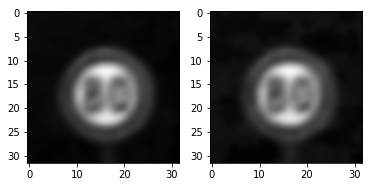

epoch 8:
loss_D: 0.304, loss_G_fake: 0.432,             
loss_perturb: 6.535, loss_adv: 96.225, 

accuracy in training set after perturbation: 80.987959



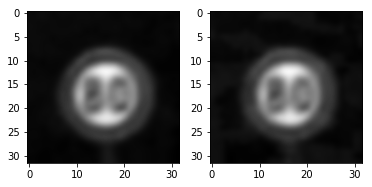

epoch 9:
loss_D: 0.306, loss_G_fake: 0.437,             
loss_perturb: 6.136, loss_adv: 94.793, 

accuracy in training set after perturbation: 79.918963



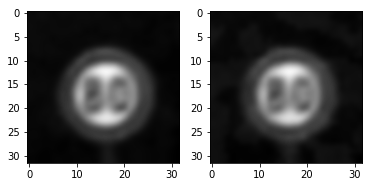

epoch 10:
loss_D: 0.304, loss_G_fake: 0.443,             
loss_perturb: 5.826, loss_adv: 93.611, 

accuracy in training set after perturbation: 78.941924



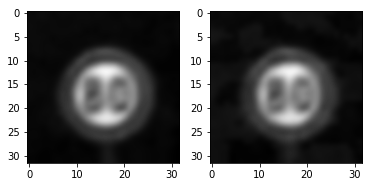

epoch 11:
loss_D: 0.289, loss_G_fake: 0.458,             
loss_perturb: 5.422, loss_adv: 92.343, 

accuracy in training set after perturbation: 77.939021



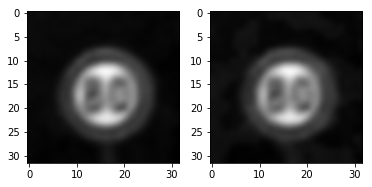

epoch 12:
loss_D: 0.292, loss_G_fake: 0.457,             
loss_perturb: 5.385, loss_adv: 91.401, 

accuracy in training set after perturbation: 77.214862



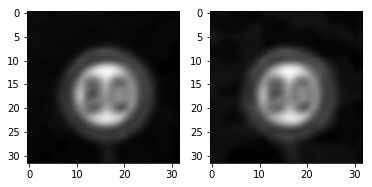

epoch 13:
loss_D: 0.289, loss_G_fake: 0.462,             
loss_perturb: 5.835, loss_adv: 90.765, 

accuracy in training set after perturbation: 76.740711



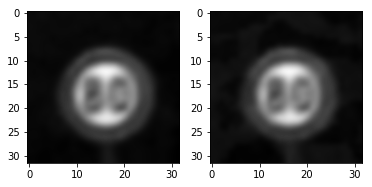

epoch 14:
loss_D: 0.302, loss_G_fake: 0.458,             
loss_perturb: 5.382, loss_adv: 90.021, 

accuracy in training set after perturbation: 76.157361



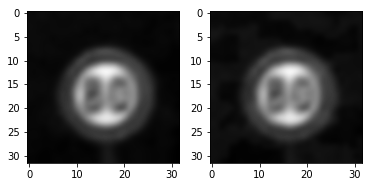

epoch 15:
loss_D: 0.299, loss_G_fake: 0.461,             
loss_perturb: 5.191, loss_adv: 89.132, 

accuracy in training set after perturbation: 75.467686



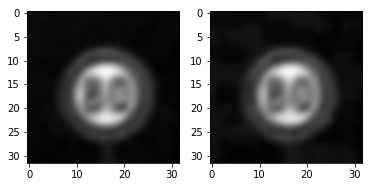

epoch 16:
loss_D: 0.293, loss_G_fake: 0.468,             
loss_perturb: 4.941, loss_adv: 88.507, 

accuracy in training set after perturbation: 74.910199



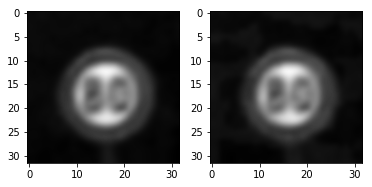

epoch 17:
loss_D: 0.294, loss_G_fake: 0.471,             
loss_perturb: 5.151, loss_adv: 87.901, 

accuracy in training set after perturbation: 74.404437



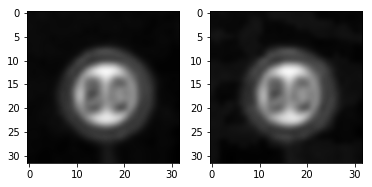

epoch 18:
loss_D: 0.290, loss_G_fake: 0.475,             
loss_perturb: 4.670, loss_adv: 87.450, 

accuracy in training set after perturbation: 73.976264



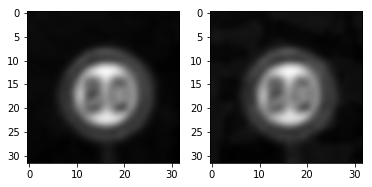

epoch 19:
loss_D: 0.285, loss_G_fake: 0.483,             
loss_perturb: 4.838, loss_adv: 86.776, 

accuracy in training set after perturbation: 73.476249



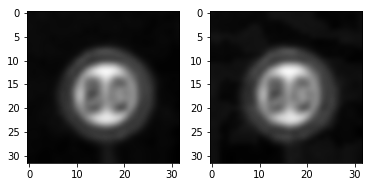

epoch 20:
loss_D: 0.293, loss_G_fake: 0.475,             
loss_perturb: 4.497, loss_adv: 86.247, 

accuracy in training set after perturbation: 73.056697



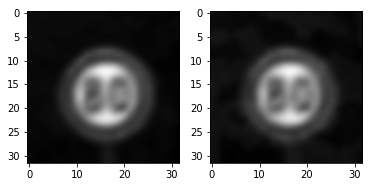

epoch 21:
loss_D: 0.286, loss_G_fake: 0.483,             
loss_perturb: 4.323, loss_adv: 85.709, 

accuracy in training set after perturbation: 72.594040



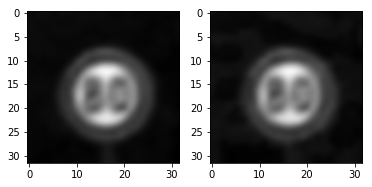

epoch 22:
loss_D: 0.274, loss_G_fake: 0.495,             
loss_perturb: 4.276, loss_adv: 85.445, 

accuracy in training set after perturbation: 72.507831



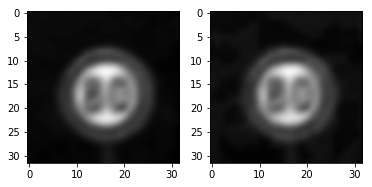

epoch 23:
loss_D: 0.286, loss_G_fake: 0.490,             
loss_perturb: 4.560, loss_adv: 85.118, 

accuracy in training set after perturbation: 72.148625



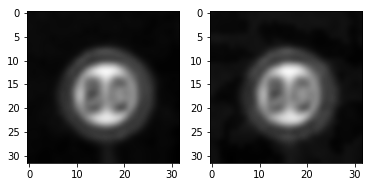

epoch 24:
loss_D: 0.287, loss_G_fake: 0.491,             
loss_perturb: 4.200, loss_adv: 84.714, 

accuracy in training set after perturbation: 71.881376



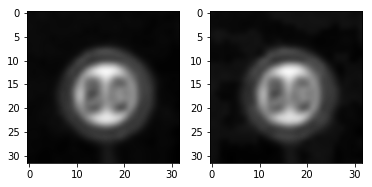

epoch 25:
loss_D: 0.273, loss_G_fake: 0.502,             
loss_perturb: 4.433, loss_adv: 84.345, 

accuracy in training set after perturbation: 71.545159



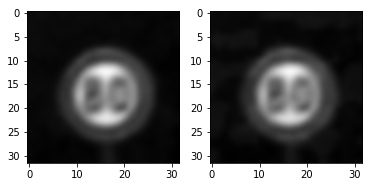

epoch 26:
loss_D: 0.265, loss_G_fake: 0.511,             
loss_perturb: 4.497, loss_adv: 84.131, 

accuracy in training set after perturbation: 71.407224



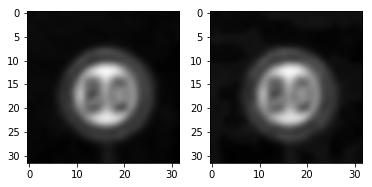

epoch 27:
loss_D: 0.268, loss_G_fake: 0.509,             
loss_perturb: 4.471, loss_adv: 83.951, 

accuracy in training set after perturbation: 71.473318



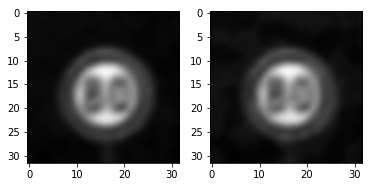

epoch 28:
loss_D: 0.254, loss_G_fake: 0.519,             
loss_perturb: 4.057, loss_adv: 83.270, 

accuracy in training set after perturbation: 70.668697



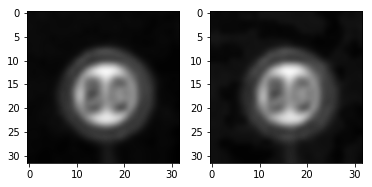

epoch 29:
loss_D: 0.265, loss_G_fake: 0.514,             
loss_perturb: 4.106, loss_adv: 83.160, 

accuracy in training set after perturbation: 70.645708



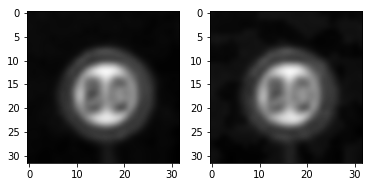

epoch 30:
loss_D: 0.251, loss_G_fake: 0.530,             
loss_perturb: 3.952, loss_adv: 82.981, 

accuracy in training set after perturbation: 70.536510



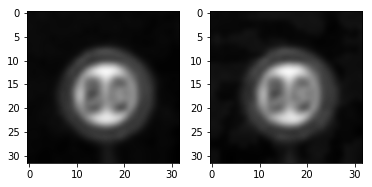

epoch 31:
loss_D: 0.254, loss_G_fake: 0.528,             
loss_perturb: 3.893, loss_adv: 82.470, 

accuracy in training set after perturbation: 69.990517



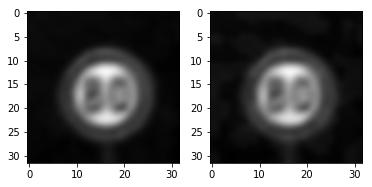

epoch 32:
loss_D: 0.248, loss_G_fake: 0.530,             
loss_perturb: 3.788, loss_adv: 82.199, 

accuracy in training set after perturbation: 69.795109



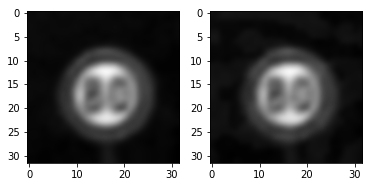

epoch 33:
loss_D: 0.245, loss_G_fake: 0.537,             
loss_perturb: 3.742, loss_adv: 82.154, 

accuracy in training set after perturbation: 69.800856



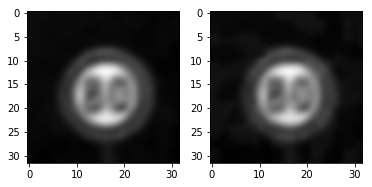

epoch 34:
loss_D: 0.233, loss_G_fake: 0.548,             
loss_perturb: 3.657, loss_adv: 81.749, 

accuracy in training set after perturbation: 69.407167



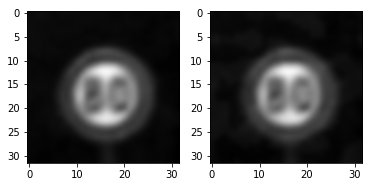

epoch 35:
loss_D: 0.233, loss_G_fake: 0.548,             
loss_perturb: 3.764, loss_adv: 81.716, 

accuracy in training set after perturbation: 69.407167



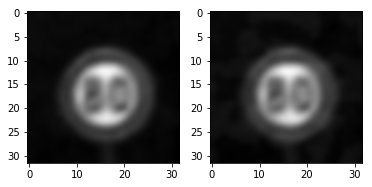

epoch 36:
loss_D: 0.237, loss_G_fake: 0.550,             
loss_perturb: 3.669, loss_adv: 81.681, 

accuracy in training set after perturbation: 69.450272



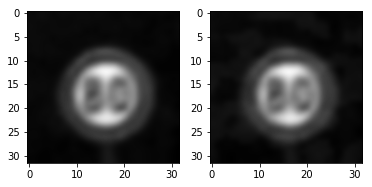

epoch 37:
loss_D: 0.223, loss_G_fake: 0.559,             
loss_perturb: 3.584, loss_adv: 81.317, 

accuracy in training set after perturbation: 69.162907



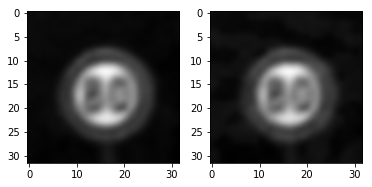

epoch 38:
loss_D: 0.230, loss_G_fake: 0.558,             
loss_perturb: 3.510, loss_adv: 80.966, 

accuracy in training set after perturbation: 68.806575



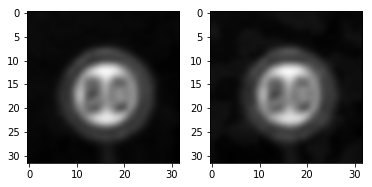

epoch 39:
loss_D: 0.223, loss_G_fake: 0.563,             
loss_perturb: 3.628, loss_adv: 80.988, 

accuracy in training set after perturbation: 68.852553



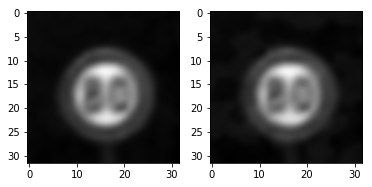

epoch 40:
loss_D: 0.229, loss_G_fake: 0.563,             
loss_perturb: 3.794, loss_adv: 80.766, 

accuracy in training set after perturbation: 68.711745



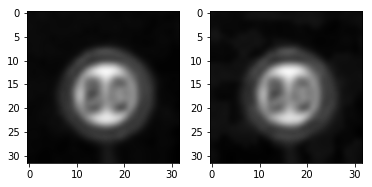

epoch 41:
loss_D: 0.215, loss_G_fake: 0.578,             
loss_perturb: 4.041, loss_adv: 80.738, 

accuracy in training set after perturbation: 68.651398



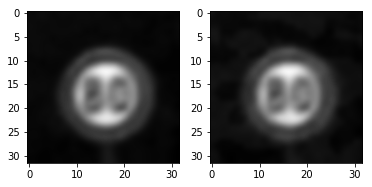

epoch 42:
loss_D: 0.222, loss_G_fake: 0.575,             
loss_perturb: 3.783, loss_adv: 80.437, 

accuracy in training set after perturbation: 68.358286



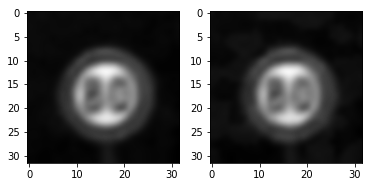

epoch 43:
loss_D: 0.220, loss_G_fake: 0.575,             
loss_perturb: 3.575, loss_adv: 80.316, 

accuracy in training set after perturbation: 68.358286



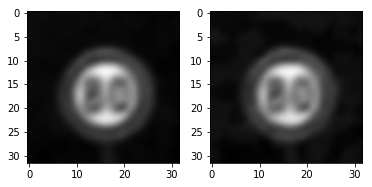

epoch 44:
loss_D: 0.220, loss_G_fake: 0.577,             
loss_perturb: 3.819, loss_adv: 80.443, 

accuracy in training set after perturbation: 68.608293



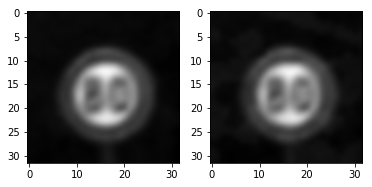

epoch 45:
loss_D: 0.209, loss_G_fake: 0.589,             
loss_perturb: 3.654, loss_adv: 79.940, 

accuracy in training set after perturbation: 67.904250



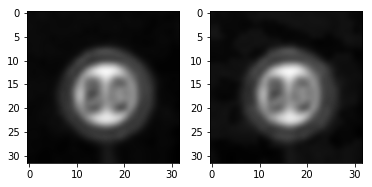

epoch 46:
loss_D: 0.219, loss_G_fake: 0.575,             
loss_perturb: 3.457, loss_adv: 79.684, 

accuracy in training set after perturbation: 67.579528



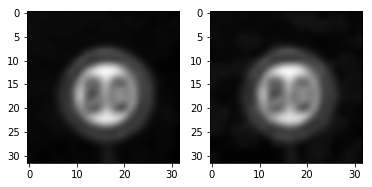

epoch 47:
loss_D: 0.214, loss_G_fake: 0.584,             
loss_perturb: 3.550, loss_adv: 79.680, 

accuracy in training set after perturbation: 67.818041



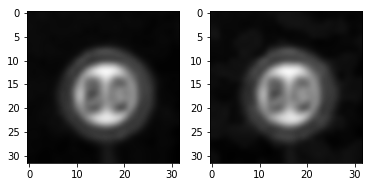

epoch 48:
loss_D: 0.217, loss_G_fake: 0.585,             
loss_perturb: 3.414, loss_adv: 79.477, 

accuracy in training set after perturbation: 67.510561



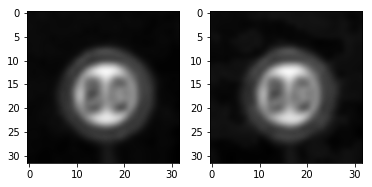

epoch 49:
loss_D: 0.203, loss_G_fake: 0.595,             
loss_perturb: 3.403, loss_adv: 79.339, 

accuracy in training set after perturbation: 67.438720



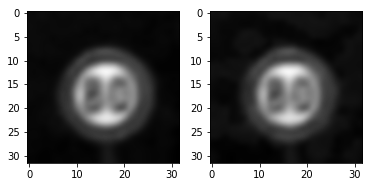

epoch 50:
loss_D: 0.148, loss_G_fake: 0.624,             
loss_perturb: 3.494, loss_adv: 78.569, 

accuracy in training set after perturbation: 66.389839



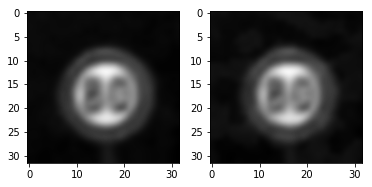

In [85]:

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



use_cuda=True
image_nc=1
epochs = 50



batch_size = 128
BOX_MIN = 0
BOX_MAX = 1

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

pretrained_model = "./target_model.pth"
targeted_model = target_net().to(device)
targeted_model.load_state_dict(torch.load(pretrained_model))
targeted_model.eval()

#test to make sure restoring model worked
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    test_label = torch.argmax(test_label,1)
    pred_lab = torch.argmax(targeted_model(test_img), 1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('accuracy in testing set: %f\n'%(100*num_correct.item()/len(test_dataset)))


model_num_labels = 43

models_path = "./models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
            
# train dataset and dataloader declaration
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
advGAN = AdvGAN_Attack(device,
                          targeted_model,
                          model_num_labels,
                          image_nc,
                          BOX_MIN,
                          BOX_MAX)

advGAN.train(dataloader, epochs)